In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import datetime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

### Read Data

In [ ]:
def read_data(file_name):
  df = pd.read_csv(f'/content/drive/My Drive/DeepLearning/crypto_data/{file_name}.csv', names=['time', 'low', 'high', 'open', 'close', 'volume'])
  df.set_index('time', inplace=True)
  return df 

In [ ]:
file_names = ['BCH-USD', 'BTC-USD', 'ETH-USD', 'LTC-USD']

In [ ]:
bch_df = read_data(file_names[0])
btc_df = read_data(file_names[1])
eth_df = read_data(file_names[2])
ltc_df = read_data(file_names[3])

In [ ]:
btc_df.head()

,low,high,open,close,volume
time,,,,,
1528968660,6489.549805,6489.560059,6489.560059,6489.549805,0.587100
1528968720,6487.370117,6489.560059,6489.549805,6487.379883,7.706374
1528968780,6479.410156,6487.370117,6487.370117,6479.410156,3.088252
1528968840,6479.410156,6479.419922,6479.419922,6479.410156,1.404100
1528968900,6475.930176,6479.979980,6479.410156,6479.979980,0.753000


In [ ]:
def join_df(main_df, input_df, crypto_name):
  
  input_df.rename(columns={'close': f'{crypto_name}_close', 'volume': f'{crypto_name}_volume'}, inplace=True)
  input_df = input_df[[f'{crypto_name}_close', f'{crypto_name}_volume']]

  if len(main_df) == 0:
    main_df = input_df
  else:
    main_df = main_df.join(input_df)

  return main_df

In [ ]:
all4_df = pd.DataFrame()

all4_df = join_df(all4_df, bch_df, 'BCH')
all4_df = join_df(all4_df, btc_df, 'BTC')
all4_df = join_df(all4_df, eth_df, 'ETH')
all4_df = join_df(all4_df, ltc_df, 'LTC')

In [ ]:
all4_df.fillna(method="ffill", inplace=True)
all4_df.dropna(inplace=True)

In [ ]:
all4_df.head()

,BCH_close,BCH_volume,BTC_close,BTC_volume,ETH_close,ETH_volume,LTC_close,LTC_volume
time,,,,,,,,
1528968720,870.859985,26.856577,6487.379883,7.706374,486.01001,26.019083,96.660004,314.387024
1528968780,870.099976,1.124300,6479.410156,3.088252,486.00000,8.449400,96.570000,77.129799
1528968840,870.789978,1.749862,6479.410156,1.404100,485.75000,26.994646,96.500000,7.216067
1528968900,870.000000,1.680500,6479.979980,0.753000,486.00000,77.355759,96.389999,524.539978
1528968960,869.989990,1.669014,6480.000000,1.490900,486.00000,7.503300,96.519997,16.991997


In [ ]:
all4_df.shape

(92224, 8)

In [ ]:
all4_df.dtypes

BCH_close     float64
BCH_volume    float64
BTC_close     float64
BTC_volume    float64
ETH_close     float64
ETH_volume    float64
LTC_close     float64
LTC_volume    float64
dtype: object

In [ ]:
training_items = int(all4_df.shape[0]*.9)
print(f'Number of training items: {training_items}. Number of test items: {all4_df.shape[0]-training_items}.')

Number of training items: 83001. Number of test items: 9223.


### Create Label

In [ ]:
SEQ_LEQ = 30
FORECAST_PERIOD = 1

In [ ]:
def classify(current, future):
    if float(future) > float(current):
        return 1
    else:
        return 0

In [ ]:
all4_df['Future'] = all4_df['LTC_close'].shift(-FORECAST_PERIOD)

In [ ]:
all4_df['Label'] = list(map(classify, all4_df['LTC_close'], all4_df['Future']))

In [ ]:
all4_df.head()

,BCH_close,BCH_volume,BTC_close,BTC_volume,ETH_close,ETH_volume,LTC_close,LTC_volume,Future,Label
time,,,,,,,,,,
1528968720,870.859985,26.856577,6487.379883,7.706374,486.01001,26.019083,96.660004,314.387024,96.570000,0
1528968780,870.099976,1.124300,6479.410156,3.088252,486.00000,8.449400,96.570000,77.129799,96.500000,0
1528968840,870.789978,1.749862,6479.410156,1.404100,485.75000,26.994646,96.500000,7.216067,96.389999,0
1528968900,870.000000,1.680500,6479.979980,0.753000,486.00000,77.355759,96.389999,524.539978,96.519997,1
1528968960,869.989990,1.669014,6480.000000,1.490900,486.00000,7.503300,96.519997,16.991997,96.440002,0


### Creating Sequences

In [ ]:
train_samples = int(all4_df.shape[0] * 0.9)

train_ = all4_df.iloc[:train_samples]
validation_ = all4_df.iloc[train_samples:]

In [ ]:
train_.head()

,BCH_close,BCH_volume,BTC_close,BTC_volume,ETH_close,ETH_volume,LTC_close,LTC_volume,Future,Label
time,,,,,,,,,,
1528968720,870.859985,26.856577,6487.379883,7.706374,486.01001,26.019083,96.660004,314.387024,96.570000,0
1528968780,870.099976,1.124300,6479.410156,3.088252,486.00000,8.449400,96.570000,77.129799,96.500000,0
1528968840,870.789978,1.749862,6479.410156,1.404100,485.75000,26.994646,96.500000,7.216067,96.389999,0
1528968900,870.000000,1.680500,6479.979980,0.753000,486.00000,77.355759,96.389999,524.539978,96.519997,1
1528968960,869.989990,1.669014,6480.000000,1.490900,486.00000,7.503300,96.519997,16.991997,96.440002,0


In [ ]:
import random
from collections import deque
from sklearn import preprocessing

In [ ]:
def preprocess(df):

    df = df.drop('Future', 1)

    for col in df.columns: 
        if col != 'Label': 
            df[col] = df[col].pct_change() 
            df.dropna(inplace=True) 
            df[col] = preprocessing.scale(df[col].values)

    df.dropna(inplace=True)

    sequential_data = [] 
    prev_days = deque(maxlen=SEQ_LEQ)

    for i in df.values:
      prev_days.append([n for n in i[:-1]]) 
      if len(prev_days) == SEQ_LEQ: 
        sequential_data.append([np.array(prev_days), i[-1]]) 

    random.shuffle(sequential_data)

    ups = [] 
    downs = []  

    for seq, label in sequential_data: 
        if label == 1:  
            ups.append([seq, label]) 
        elif label == 0:
            downs.append([seq, label]) 

    random.shuffle(downs) 
    random.shuffle(ups)

    lower = min(len(downs), len(ups))

    ups = ups[:lower]  
    downs = downs[:lower]

    sequential_data = ups+downs  

    random.shuffle(sequential_data) 

    return sequential_data

In [ ]:
train_sequences = preprocess(train_)
test_sequences = preprocess(validation_)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

device = "cuda"

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)
torch.manual_seed(0)

### Convert to Tensor

In [ ]:
def tensor_converter_e(sequence, label):

  label_tensor = torch.tensor(label).to(device)
  # label_tensor_zero = torch.zeros(1).to(device)
  seq_tensor = torch.tensor(sequence).to(device)

  return seq_tensor, label_tensor.long()
  # return seq_tensor, label_tensor_zero.long()

In [ ]:
train_sequences_tensor = [tensor_converter_e(seq, label) for seq, label in train_sequences]
test_sequences_tensor = [tensor_converter_e(seq, label) for seq, label in test_sequences]

### OneLayer LSTM

In [ ]:
from pprint import pprint

In [ ]:
class ShallowLSTM(nn.Module):

  def __init__(self, hparams):
    super(ShallowLSTM, self).__init__()

    pprint(params)

    self.input_projection = nn.Sequential(
        nn.Linear(hparams.input_projection, hparams.embedding_dim//2),
        nn.Tanh(),
        nn.Linear(hparams.embedding_dim//2, hparams.embedding_dim),
    )

    self.lstm = nn.LSTM(hparams.embedding_dim, hparams.hidden_dim, 
                        bidirectional=hparams.bidirectional,
                        num_layers=hparams.num_layers, 
                        dropout = hparams.dropout,
                        batch_first = True)

    lstm_output_dim = hparams.hidden_dim if hparams.bidirectional is False else hparams.hidden_dim * 2

    self.dropout = nn.Dropout(hparams.dropout)
    self.classifier = nn.Linear(lstm_output_dim, hparams.num_classes)

    self.hidden_cell = (torch.zeros(1,1,hparams.hidden_dim),
                        torch.zeros(1,1,hparams.hidden_dim))
    
  def forward(self, x):

    embeddings = self.input_projection(x.float())
    o, (h, c) = self.lstm(embeddings)
    o = self.dropout(o[:, -1])
    output = self.classifier(o)
    
    return output

  # def predict(self, x):
  #   logits = self.forward(x)
  #   predictions = torch.argmax(logits, dim=-1)
  #   return predictions

In [ ]:
class HParams():

  input_projection = 8
  hidden_dim = 32
  embedding_dim = 64
  num_classes = 2
  bidirectional = False
  num_layers = 1
  dropout = 0

params = HParams()

### Three Layer LSTM

In [ ]:
class treLSTM(nn.Module):

  def __init__(self, hparams):
    super(treLSTM, self).__init__()

    pprint(hparams)

    # self.input_projection = nn.Sequential(
    # nn.Linear(8, hparams.embedding_dim//2),
    # nn.Tanh(),
    # nn.Linear(hparams.embedding_dim//2, hparams.embedding_dim),)

    self.lstm1 = nn.LSTM(hparams.embedding_dim, hparams.hidden_dim, 
                        bidirectional=hparams.bidirectional,
                        num_layers=hparams.num_layers, 
                        dropout = hparams.dropout, 
                        batch_first = True)
    
    lstm_output_dim = hparams.hidden_dim if hparams.bidirectional is False else hparams.hidden_dim * 2


    self.lstm2 = nn.LSTM(lstm_output_dim, hparams.hidden_dim2, 
                        bidirectional=hparams.bidirectional,
                        num_layers=hparams.num_layers2, 
                        dropout = hparams.dropout2)

    lstm_output_dim2 = hparams.hidden_dim2 if hparams.bidirectional is False else hparams.hidden_dim2 * 2


    self.lstm3 = nn.LSTM(lstm_output_dim, hparams.hidden_dim3, 
                    bidirectional=hparams.bidirectional,
                    num_layers=hparams.num_layers3, 
                    dropout = hparams.dropout3)

    lstm_output_dim3 = hparams.hidden_dim3 if hparams.bidirectional is False else hparams.hidden_dim3 * 2

    self.dropout = nn.Dropout(hparams.dropout)
    self.dropout2 = nn.Dropout(hparams.dropout2)
    self.dropout3 = nn.Dropout(hparams.dropout3)


    self.projection_layer = nn.Sequential(nn.Linear(lstm_output_dim3, 32), 
                                          nn.ReLU(),
                                          nn.Linear(32, hparams.num_classes))
                              

  
  def forward(self, x):
    
    # embeddings = self.input_projection(x.float())
    o, (h, c) = self.lstm1(x.float())
    o = self.dropout(o)
    o2, (h2, c2) = self.lstm2(o)
    o2 = self.dropout2(o2)

    o3, (h3, c3) = self.lstm3(o2)
    o3 = self.dropout(o3[:, -1])

    output = self.projection_layer(o3)

    return output

  def predict(self, x):
    logits = self.forward(x)
    predictions = torch.argmax(logits, dim=-1)
    return predictions

In [ ]:
class HParams_tre():

    hidden_dim = 128
    embedding_dim = 8
    num_classes = 2
    bidirectional = True
    num_layers = 1
    dropout = 0.2


    hidden_dim2 = 128
    num_layers2 = 1
    dropout2 = 0.1

    hidden_dim3 = 128
    num_layers3 = 1
    dropout3 = 0.2

params_tre = HParams_tre()

### TwoLayer LSTM

In [ ]:
class DeepLSTM(nn.Module):

  def __init__(self, hparams):
    super(DeepLSTM, self).__init__()

    pprint(params2)

    self.input_projection = nn.Sequential(
    nn.Linear(8, hparams.embedding_dim//2),
    nn.Tanh(),
    nn.Linear(hparams.embedding_dim//2, hparams.embedding_dim),)

    self.lstm1 = nn.LSTM(hparams.embedding_dim, hparams.hidden_dim, 
                        bidirectional=hparams.bidirectional,
                        num_layers=hparams.num_layers, 
                        dropout = hparams.dropout, 
                        batch_first = True)
    
    lstm_output_dim = hparams.hidden_dim if hparams.bidirectional is False else hparams.hidden_dim * 2
    
    self.lstm2 = nn.LSTM(lstm_output_dim, hparams.hidden_dim2, 
                        bidirectional=hparams.bidirectional,
                        num_layers=hparams.num_layers2, 
                        dropout = hparams.dropout2)

    lstm_output_dim2 = hparams.hidden_dim2 if hparams.bidirectional is False else hparams.hidden_dim2 * 2

    self.dropout = nn.Dropout(hparams.dropout)
    self.dropout2 = nn.Dropout(hparams.dropout2)


    self.projection_layer = nn.Sequential(nn.Linear(lstm_output_dim2, 32), 
                                          nn.ReLU(),
                                          nn.Linear(32, 16),
                                          nn.ReLU(),
                                          nn.Linear(16, hparams.num_classes))
                              

  
  def forward(self, x):
    
    embeddings = self.input_projection(x.float())
    o, (h, c) = self.lstm1(embeddings)
    o = self.dropout(o)
    o2, (h2, c2) = self.lstm2(o)
    # o2 = self.dropout2(o2)
    o2 = self.dropout(o2[:, -1])

    output = self.projection_layer(o2)

    return output

  def predict(self, x):
    logits = self.forward(x)
    predictions = torch.argmax(logits, dim=-1)
    return predictions

In [ ]:
class HParamsD():

    hidden_dim = 128
    embedding_dim = 64
    num_classes = 2
    bidirectional = False
    num_layers = 1
    dropout = 0.2


    hidden_dim2 = 64
    num_layers2 = 1
    dropout2 = 0

params2 = HParamsD()

### Trainer Class

In [ ]:
class Trainer():

  def __init__(
    self,
    model: nn.Module,
    loss_function,
    optimizer):

    self.model = model
    self.loss_function = loss_function
    self.optimizer = optimizer

  def train(self, train_dataset, 
            valid_dataset, 
            epochs):

    train_loss = 0.0
    for epoch in range(epochs):
      print(f'Epoch {epoch+1}')

      epoch_loss = 0.0
      self.model.train()

      for step, sentence in enumerate(train_dataset):

        tokens = sentence[0]
        labels = sentence[1]

        self.optimizer.zero_grad()

        predictions = self.model(tokens)
        predictions = predictions.view(-1, predictions.shape[-1])
        labels = labels.view(-1)
        
        temp_loss = self.loss_function(predictions, labels)

        temp_loss.backward()
        self.optimizer.step()

        epoch_loss += temp_loss.tolist()

        
      avg_epoch_loss = epoch_loss / len(train_dataset)
      train_loss += avg_epoch_loss

      print(f'\t[Epoch: {epoch+1}] Training Loss = {avg_epoch_loss}')
      # writer.add_scalar(' Training Loss', avg_epoch_loss, epoch)

      valid_loss = self.evaluate(valid_dataset)
      
      print(f'\t[Epoch: {epoch+1}] Validation Loss = {valid_loss}')
      # writer.add_scalar('Validation Loss', valid_loss, epoch)

    print('Training has finished')
    
    avg_epoch_loss = train_loss / epochs

    return avg_epoch_loss
  

  def evaluate(self, valid_dataset):

    valid_loss = 0.0
    self.model.eval()

    with torch.no_grad():
      for sentence in valid_dataset:
        tokens = sentence[0]
        labels = sentence[1]

        predictions = self.model(tokens)
        predictions = predictions.view(-1, predictions.shape[-1])
        labels = labels.view(-1)

        temp_loss = self.loss_function(predictions, labels)
        # temp_loss = temp_loss.view(tokens.shape[0], -1)
        # temp_loss = temp_loss.sum(dim=-1).mean()
        valid_loss += temp_loss.tolist()
      
    return valid_loss / len(valid_dataset)


  def predict(self, x):

    self.model.eval()
    
    with torch.no_grad():
        logits = self.model(x)
        predictions = torch.argmax(logits, -1)
        return logits, predictions

### F-Score

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def f_score(labels, predictions):
  
  print(f'# instances: {len(labels)}')

  p = precision_score(labels, predictions, average='macro')
  r = recall_score(labels, predictions, average='macro')
  f = f1_score(labels, predictions, average='macro')

  print(f'# precision: {p:.4f}')
  print(f'# recall: {r:.4f}')
  print(f'# f1: {f:.4f}')


### Confusion Matrix

In [ ]:
def cm_plot(test_label, pred_labels):

  label=[0, 1]

  cm = confusion_matrix(test_label, pred_labels, label)
  print(cm)

  sum_col_cm = np.sum(cm, axis=1, keepdims=True)
  acc_col_cm = (cm / sum_col_cm.astype(float))

  acc_col_cm = [[round(x, 4) for x in xx] for xx in acc_col_cm]
  acc_df = pd.DataFrame(data=acc_col_cm, index=label, columns=label)

  acc_df.index.name = 'ACTUAL LABELS'
  acc_df.columns.name = 'PREDICTED LABELS'
  fig, ax = plt.subplots(figsize=(8,6))
  sns.heatmap(acc_df, annot=acc_col_cm, annot_kws={"size": 15}, fmt='', ax=ax, cmap="YlGnBu")
  plt.show()

### Prepare Batch Data

In [ ]:
train_dataset = DataLoader(train_sequences_tensor, batch_size=64)
valid_dataset = DataLoader(test_sequences_tensor, batch_size=64)

### OneLayer_F8 Training

In [ ]:
model = ShallowLSTM(params).cuda()
model

ShallowLSTM(
  (input_projection): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=64, bias=True)
  )
  (lstm): LSTM(64, 32, batch_first=True)
  (dropout): Dropout(p=0, inplace=False)
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)

In [ ]:
trainer = Trainer(
    model = model,
    loss_function = nn.CrossEntropyLoss(),
    optimizer = optim.Adam(model.parameters()),
)

In [ ]:
trainer.train(train_dataset, valid_dataset, 10)

In [ ]:
# hidden 64, embedding 64, features 8
model_save_name = 'OneLayer_H64_E64_epoch20_F8.pth'
path = f"/content/drive/My Drive/DeepLearning/models/{model_save_name}" 
torch.save(model.state_dict(), path)

#### Test

In [ ]:
predictions = []
test_labels = []

for i in range(len(test_sequences_tensor)):

  test_elem = test_sequences_tensor[i]
  test_x, test_y = test_elem[0], test_elem[1]
      
  logits, coded_pred = trainer.predict(test_x.unsqueeze(0))
  predictions.append(coded_pred[0].tolist()) 
  test_labels.append(test_y.tolist())

In [ ]:
predictions_train_one = []
train_labels = []


for i in range(len(train_sequences_tensor)):

  train_elem = train_sequences_tensor[i]
  train_x, train_y = train_elem[0], train_elem[1]
      
  logits, coded_pred = trainer.predict(train_x.unsqueeze(0))
  predictions_train_one.append(coded_pred[0].tolist()) 
  train_labels.append(train_y.tolist())

In [ ]:
predictions[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
test_labels[:10]

[0, 1, 0, 1, 0, 0, 0, 0, 0, 1]

In [ ]:
f_score(test_labels, predictions)

# instances: 6496
# precision: 0.5984
# recall: 0.5953
# f1: 0.5921


In [ ]:
f_score(train_labels, predictions_train_one)

# instances: 61788
# precision: 0.6146
# recall: 0.6114
# f1: 0.6087


In [ ]:
accuracy_score(test_labels, predictions)

0.5952894088669951

In [ ]:
accuracy_score(train_labels, predictions_train_one)

0.6114294037677219

[[1818 1430]
 [1146 2102]]


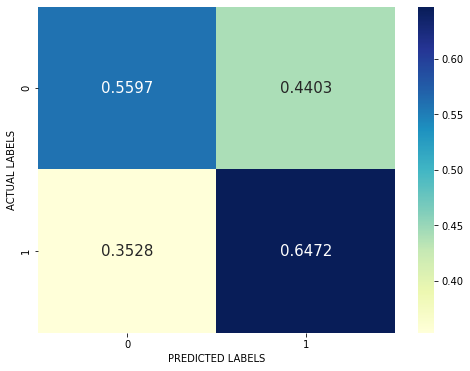

In [ ]:
cm_plot(test_labels, predictions)

### Tre LSTM trainin

In [ ]:
model_tre = treLSTM(params_tre).cuda()
model_tre

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


treLSTM(
  (lstm1): LSTM(8, 128, batch_first=True, dropout=0.2, bidirectional=True)
  (lstm2): LSTM(256, 128, dropout=0.1, bidirectional=True)
  (lstm3): LSTM(256, 128, dropout=0.2, bidirectional=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
  (dropout3): Dropout(p=0.2, inplace=False)
  (projection_layer): Sequential(
    (0): Linear(in_features=256, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=2, bias=True)
  )
)

In [ ]:
trainer_tre = Trainer(
    model = model_tre,
    loss_function = nn.CrossEntropyLoss(),
    optimizer = optim.Adam(model_tre.parameters()),
)

In [ ]:
trainer_tre.train(train_dataset, valid_dataset, 10)

Epoch 1
	[Epoch: 1] Training Loss = 0.6830947568821364
	[Epoch: 1] Validation Loss = 0.6800559408524457
Epoch 2
	[Epoch: 2] Training Loss = 0.6784608267232252
	[Epoch: 2] Validation Loss = 0.6775872783333647
Epoch 3
	[Epoch: 3] Training Loss = 0.6758389648813639
	[Epoch: 3] Validation Loss = 0.6744897967460108
Epoch 4
	[Epoch: 4] Training Loss = 0.6726367682773874
	[Epoch: 4] Validation Loss = 0.6715522940252342
Epoch 5
	[Epoch: 5] Training Loss = 0.6676498155416168
	[Epoch: 5] Validation Loss = 0.6665599690932854
Epoch 6
	[Epoch: 6] Training Loss = 0.6613071634902717
	[Epoch: 6] Validation Loss = 0.667170881056318
Epoch 7
	[Epoch: 7] Training Loss = 0.6535032311951892
	[Epoch: 7] Validation Loss = 0.6692463124499601
Epoch 8
	[Epoch: 8] Training Loss = 0.6430437703680548
	[Epoch: 8] Validation Loss = 0.6764273830488616
Epoch 9
	[Epoch: 9] Training Loss = 0.625343172539095
	[Epoch: 9] Validation Loss = 0.6846678964063233
Epoch 10
	[Epoch: 10] Training Loss = 0.6002107304260598
	[Epoch: 

0.6561089200324399

In [ ]:
model_save_name = 'tre_bidict_epoch10.pth'
path = f"/content/drive/My Drive/DeepLearning/models/{model_save_name}" 
torch.save(model_tre.state_dict(), path)

In [ ]:
predictions_tre = []
test_labels = []


for i in range(len(test_sequences_tensor)):

  test_elem = test_sequences_tensor[i]
  test_x, test_y = test_elem[0], test_elem[1]
      
  logits, coded_pred = trainer_tre.predict(test_x.unsqueeze(0))
  predictions_tre.append(coded_pred[0].tolist()) 
  test_labels.append(test_y.tolist())

In [ ]:
predictions_train_tre = []
train_labels = []


for i in range(len(train_sequences_tensor)):

  train_elem = train_sequences_tensor[i]
  train_x, train_y = train_elem[0], train_elem[1]
      
  logits, coded_pred = trainer_tre.predict(train_x.unsqueeze(0))
  predictions_train_tre.append(coded_pred[0].tolist()) 
  train_labels.append(train_y.tolist())

In [ ]:
f_score(test_labels, predictions_tre)

# instances: 6496
# precision: 0.5954
# recall: 0.5939
# f1: 0.5923


In [ ]:
f_score(train_labels, predictions_train_tre)

# instances: 61788
# precision: 0.6066
# recall: 0.6058
# f1: 0.6051


In [ ]:
accuracy_score(test_labels, predictions_tre)

0.5939039408866995

In [ ]:
accuracy_score(train_labels, predictions_train_tre)

0.6058296109276883

[[1697 1551]
 [1086 2162]]


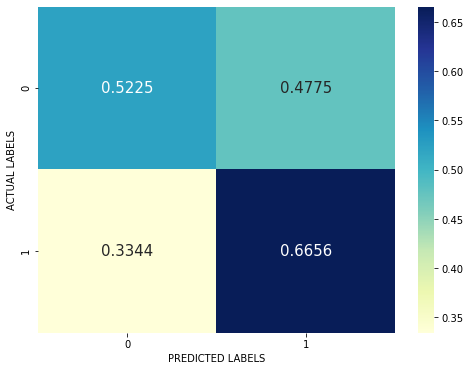

In [ ]:
cm_plot(test_labels, predictions_tre)

###Deep LSTM Training

In [ ]:
model_d = DeepLSTM(params2).cuda()
model_d

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


DeepLSTM(
  (input_projection): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=64, bias=True)
  )
  (lstm1): LSTM(64, 128, batch_first=True, dropout=0.2)
  (lstm2): LSTM(128, 64)
  (dropout): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0, inplace=False)
  (projection_layer): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=2, bias=True)
  )
)

In [ ]:
trainer_d = Trainer(
    model = model_d,
    loss_function = nn.CrossEntropyLoss(),
    optimizer = optim.Adam(model_d.parameters()),
)

In [ ]:
trainer_d.train(train_dataset, valid_dataset, 10)

Epoch 1
	[Epoch: 1] Training Loss = 0.681109053686292
	[Epoch: 1] Validation Loss = 0.6725831300604577
Epoch 2
	[Epoch: 2] Training Loss = 0.6680985778014853
	[Epoch: 2] Validation Loss = 0.6576736668745676
Epoch 3
	[Epoch: 3] Training Loss = 0.659711507104692
	[Epoch: 3] Validation Loss = 0.653757860847548
Epoch 4
	[Epoch: 4] Training Loss = 0.6562272805111256
	[Epoch: 4] Validation Loss = 0.6518857216133791
Epoch 5
	[Epoch: 5] Training Loss = 0.654601733445134
	[Epoch: 5] Validation Loss = 0.6536523010216507
Epoch 6
	[Epoch: 6] Training Loss = 0.6520194126212079
	[Epoch: 6] Validation Loss = 0.6550068154054529
Epoch 7
	[Epoch: 7] Training Loss = 0.6491431060168067
	[Epoch: 7] Validation Loss = 0.6580368923205956
Epoch 8
	[Epoch: 8] Training Loss = 0.6458153250794973
	[Epoch: 8] Validation Loss = 0.6598044470244763
Epoch 9
	[Epoch: 9] Training Loss = 0.6410028672860029
	[Epoch: 9] Validation Loss = 0.6611051559448242
Epoch 10
	[Epoch: 10] Training Loss = 0.6341135074880059
	[Epoch: 10

0.654184237104025

In [ ]:
model_save_name = 'TwoLayers_H128H64_D02_epoch10.pth'
path = f"/content/drive/My Drive/DeepLearning/models/{model_save_name}" 
torch.save(model_d.state_dict(), path)

In [ ]:
best_model = 

model_save_name = 'TwoLayers_H128H64_D02_epoch10.pth'
path = f"/content/drive/My Drive/DeepLearning/models/{model_save_name}" 
torch.load_sta(model_d.state_dict(), path)

#### Test

In [ ]:
predictions = []
test_labels = []

for i in range(len(test_sequences_tensor)):

  test_elem = test_sequences_tensor[i]
  test_x, test_y = test_elem[0], test_elem[1]
      
  logits, coded_pred = trainer_d.predict(test_x.unsqueeze(0))
  predictions.append(coded_pred[0].tolist()) 
  test_labels.append(test_y.tolist())

In [ ]:
predictions_d_train_two = []

for i in range(len(train_sequences_tensor)):

  train_elem = train_sequences_tensor[i]
  train_x, train_y = train_elem[0], train_elem[1]
      
  logits, coded_pred = trainer_d.predict(train_x.unsqueeze(0))
  predictions_d_train_two.append(coded_pred[0].tolist()) 

In [ ]:
f_score(test_labels, predictions)

# instances: 6496
# precision: 0.6142
# recall: 0.6142
# f1: 0.6142


In [ ]:
print(f_score(train_labels, predictions_d_train_two))
print(accuracy_score(train_labels, predictions_d_train_two))
print(accuracy_score(test_labels, predictions_d))

[[1975 1273]
 [1233 2015]]


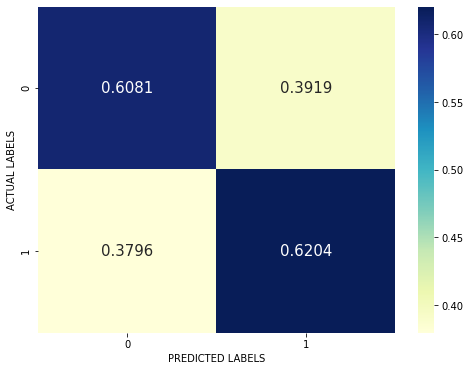

In [ ]:
cm_plot(test_labels, predictions)

In [ ]:
accuracy_score(test_labels, predictions_d1)

0.5398645696810834

### Adding Technical Indicators

In [ ]:
def technical_indicators(dataset):

    adjClose = dataset['LTC_close']

    # Create 7 and 21 days Moving Average
    dataset['ma7'] = adjClose.rolling(window=7).mean()
    dataset['ma21'] = adjClose.rolling(window=21).mean()
    
    # Create MACD
    dataset['26ema'] = adjClose.ewm(span=26).mean()
    dataset['12ema'] = adjClose.ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    dataset['20sd'] = adjClose.rolling(window=20,center=False).std() 
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = adjClose.ewm(com=0.5).mean()
    
    # Create RSI
    delta = adjClose.diff()
    delta = delta[1:] 

    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    # Calculate the SMA
    roll_up = up.rolling(14).mean()
    roll_down = down.abs().rolling(14).mean()

    # Calculate the RSI based on SMA
    RS = roll_up / roll_down
    dataset['RSI'] = 100.0 - (100.0 / (1.0 + RS))
    
    return dataset

In [ ]:
all4_df_t = technical_indicators(all4_df)

In [ ]:
all4_df_t = all4_df_t[20:]

In [ ]:
all4_df_t.head()

,BCH_close,BCH_volume,BTC_close,BTC_volume,ETH_close,ETH_volume,LTC_close,LTC_volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,RSI
time,,,,,,,,,,,,,,,,,,
1528969920,873.650024,1.198600,6486.359863,1.065600,488.00000,101.905365,96.629997,65.206299,96.518570,96.478571,96.487900,96.508591,0.020691,0.075913,96.630396,96.326746,96.599981,61.764723
1528969980,873.859985,1.293300,6487.259766,0.602759,487.98999,303.575714,96.599998,206.481979,96.547141,96.475714,96.498075,96.523019,0.024944,0.078263,96.632239,96.319189,96.599992,65.625127
1528970040,873.750000,7.357900,6487.270020,0.427600,488.00000,20.277039,96.639999,35.712299,96.578570,96.479047,96.510746,96.541411,0.030664,0.086789,96.652626,96.305468,96.626663,67.647279
1528970100,873.309998,2.864491,6490.000000,0.516043,487.98999,20.961819,96.660004,119.928459,96.591427,96.486666,96.523872,96.559993,0.036121,0.093147,96.672961,96.300372,96.648890,68.571890
1528970160,873.309998,0.149200,6490.000000,0.742156,488.00000,19.020500,96.660004,27.055300,96.615714,96.499524,96.535680,96.575619,0.039939,0.100382,96.700287,96.298760,96.656299,68.571890
